In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import scIB
import pickle
import warnings
warnings.filterwarnings('ignore')
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)

In [2]:
default_fig_size = (8,8)
plt.rcParams['figure.figsize'] = default_fig_size

## Raw

In [3]:
adata_file = "/storage/groups/ml01/workspace/group.daniela/atlases_merged.h5ad"
adata_file = "/storage/groups/ml01/workspace/group.daniela/mca_tm_liv_kid_pan.h5ad"
adata = sc.read(adata_file, cache=True)

In [4]:
adata

AnnData object with n_obs × n_vars = 29786 × 18695 
    obs: 'barcode', 'batch', 'cell_type', 'cell_type_union', 'channel', 'log_counts', 'marker_gene', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'sample_id', 'sex', 'size_factors', 'study', 'tissue', 'louvain'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-1-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'neighbors', 'pca', 'study_colors', 'tissue_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [5]:
scIB.pp.summarize_counts(adata)

In [6]:
scIB.preprocessing.reduce_data(adata, neighbors=False, umap=False)

HVG
filtered out 778 genes that are detectedin less than 1 cells
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Computed 1999 highly variable genes
PCA
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:03)


In [7]:
#scIB.cl.opt_louvain(adata, plot=True, force=True)
sc.tl.louvain(adata, resolution=2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 190 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)


In [ ]:
sc.pl.umap(adata, color=['tissue', 'study', 'n_counts', 'louvain'])
sc.pl.pca(adata, color=['tissue', 'study', 'n_counts', 'louvain'])

### Scores

In [8]:
results = scIB.me.metrics(adata, cell_cycle_=False, group_key='cell_type_union', cluster_key='louvain',
                 kBET_=False, verbose=False)

silhouette score...
NMI...
ARI...
PC regression...


In [13]:
from scIB.metrics import *

In [21]:
def metrics_all(adata_dict,
                batch_key='study', group_key='cell_type', cluster_key=None,
                silhouette_=True,  si_embed='X_pca', si_metric='euclidean',
                nmi_=True, ari_=True, nmi_method='max', nmi_dir=None,
                pcr_=True, kBET_=True, kBET_sub=0.5,
                cell_cycle_=True, hvg=True, verbose=False
               ):#
    """
    summary of all metrics for all tools in a DataFrame
    params:
        adata_dict: list of adata results from different integration methods
            ["seurat", "scanorama", "mnn", "scGen", "Harmony", "CONOS"]
    """
    
    results = pd.DataFrame(columns=adata_dict.keys())
    for tool, adata in adata_dict.items():
        single_result = metrics(adata, adata.X, 
                                batch_key=batch_key, group_key=group_key, cluster_key=cluster_key,
                                silhouette_=silhouette_,  si_embed=si_embed, si_metric=si_metric,
                                nmi_=nmi_, ari_=ari_, nmi_method=nmi_method, nmi_dir=nmi_dir,
                                pcr_=pcr_, kBET_=kBET_, kBET_sub=kBET_sub,
                                cell_cycle_=cell_cycle_, hvg=hvg, verbose=verbose)
        results[tool] = single_result.iloc[:,0]
    
    return results.transpose()

In [ ]:
metrics_all({'test1': adata, 'test2': adata}, silhouette_=True, pcr_=True, cell_cycle_=False, group_key='cell_type_union',
            cluster_key='louvain', kBET_=False, verbose=False)

silhouette score...


## Integrated

In [49]:
adata_file = "/storage/groups/ml01/workspace/group.daniela/tm/integrated/scanorama.h5ad"
adata_int = sc.read(adata_file, cache=True)

In [50]:
adata_int

AnnData object with n_obs × n_vars = 133340 × 18756 
    obs: 'barcode', 'batch', 'cell_type', 'cell_type_union', 'channel', 'log_counts', 'marker_gene', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'sample_id', 'sex', 'size_factors', 'study', 'tissue'
    uns: 'emb', 'mem', 'runtime'
    obsm: 'X_pca'

In [51]:
scIB.pp.summarize_counts(adata_int)

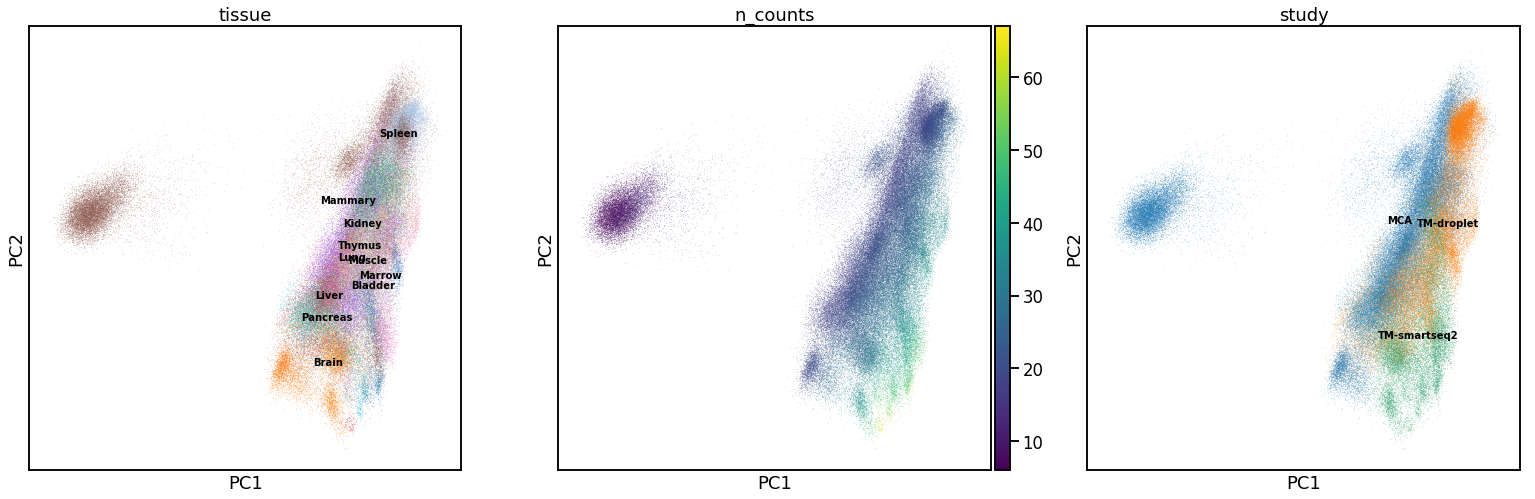

In [61]:
sc.pl.pca(adata_int, color=['tissue', 'n_counts', 'study'], legend_loc='on data', palette=sc.pl.palettes.default_20)

In [53]:
adata_int.obsm['X_integrated'] = adata.obsm['X_pca']

In [54]:
scIB.preprocessing.reduce_data(adata_int, pca=False, hvg=False)

Nearest Neigbours
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:33)
UMAP
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:47)


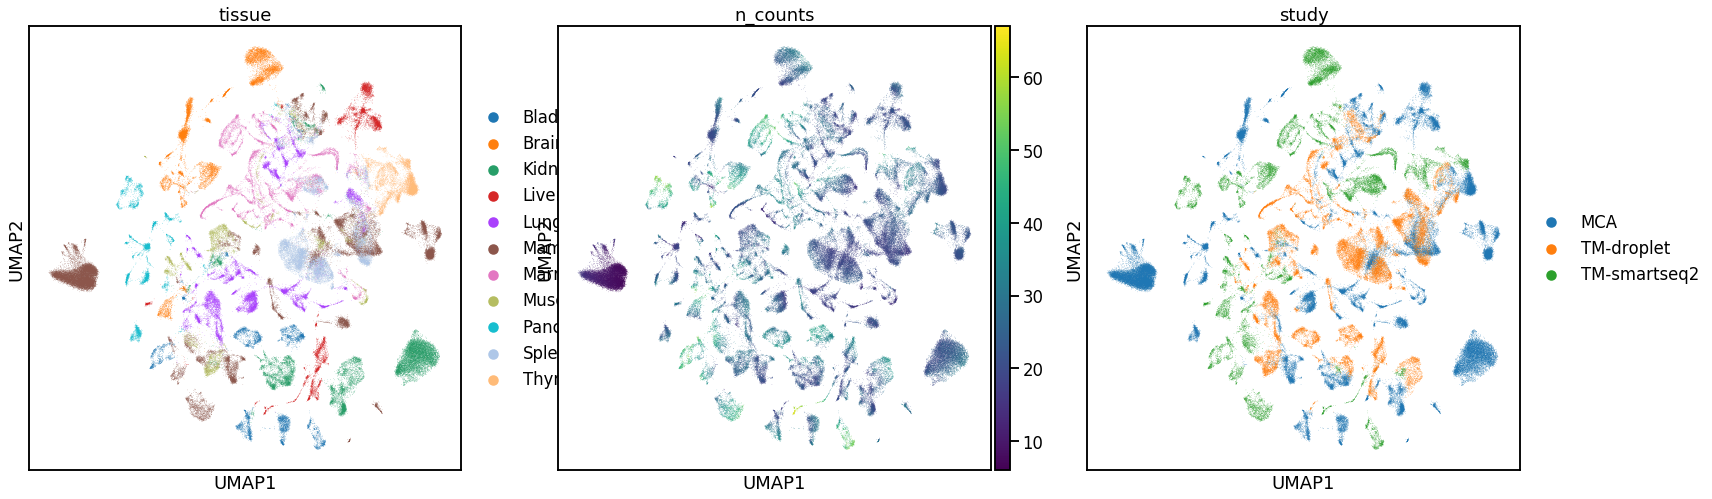

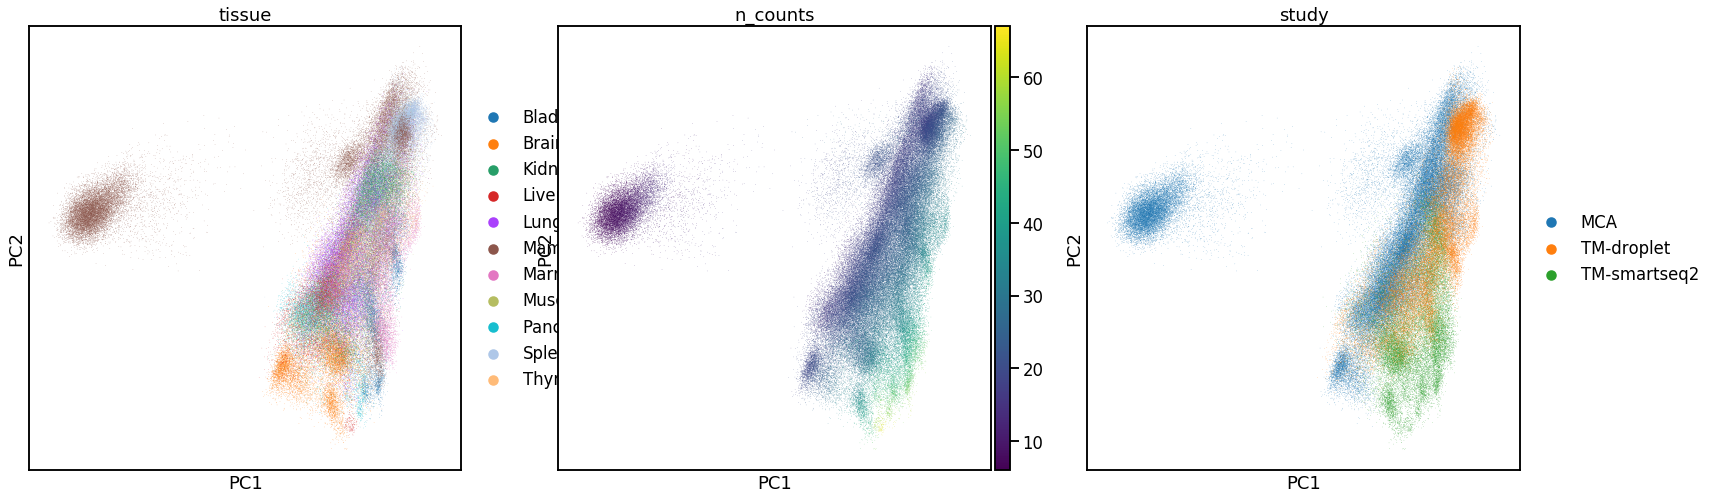

In [55]:
sc.pl.umap(adata_int, color=['tissue', 'n_counts', 'study'])
sc.pl.pca(adata_int, color=['tissue', 'n_counts', 'study'])

### Scores

In [82]:
n=20
resolutions = [x/n for x in range(11,n+1)]
scIB.cl.opt_louvain(adata_int, resolution=resolutions, plot=True, force=True)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 51 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:23)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 53 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:23)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 56 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:23)
running Louvain clustering
    using the "louvain" package of Traag (2017)


KeyboardInterrupt: 

## Comparison